# Transfer Learning

In [1]:
import sys

from tqdm.auto import tqdm

sys.path.append('..')

import keras
import numpy as np

from src.TrainProdecure import train_single_model
from src.ModelBuilder import get_FCN
from src.LoadData import get_all_datasets_names_paths, get_all_datasets_test_train_np_arrays, CurrentDatasets


In [18]:
EPOCHS_PER_TRAINING = 20
FINE_TUNE_DATASETS = CurrentDatasets.electric_devices.value, CurrentDatasets.coffee_beans.value, CurrentDatasets.share_price_increase.value
EVALUATION_DATASET = CurrentDatasets.freezers.value
GENERATE_MODEL = get_FCN

In [3]:
def headless(model):
    return model.layers[1:-1]

In [4]:
def freeze_layers(list_of_layers):
    for layer in list_of_layers:
        layer.trainable = False

In [5]:
def unfreeze_model(model):
    for layer in model.layers:
        layer.trainable = True

In [6]:
ds = get_all_datasets_test_train_np_arrays('../datasets/')

## Train a model from scratch

This is the baseline for comparison with fine-tuned training

In [20]:
x_train, y_train = ds[EVALUATION_DATASET]['train_data']
x_test, y_test = ds[EVALUATION_DATASET]['test_data']

input_size = x_train.shape[1]
output_size = len(np.unique(y_train))

scratch_model = GENERATE_MODEL(input_size, output_size)
scratch_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 301, 128)          1152      
                                                                 
 batch_normalization_6 (Batc  (None, 301, 128)         512       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 301, 128)          0         
                                                                 
 conv1d_15 (Conv1D)          (None, 301, 256)          164096    
                                                                 
 batch_normalization_7 (Batc  (None, 301, 256)         1024      
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 301, 256)        

In [21]:
_, loss, acc, from_scratch_history = train_single_model(
    scratch_model, x_train, y_train, x_test, y_test,
    epochs=EPOCHS_PER_TRAINING, batch_size=None, model_name='FCN', dataset_name=EVALUATION_DATASET
)

Training FCN on freezers dataset: 0epoch [00:00, ?epoch/s]

90/90 [==============================] - 2s 26ms/step - loss: 0.9524 - accuracy: 0.5000


## Train the model completely on each dataset

In [9]:
fine_tuning_model = GENERATE_MODEL(1, 1)
headless_model_layers = headless(fine_tuning_model)

In [10]:
# First round with full training
for dataset_name in tqdm(FINE_TUNE_DATASETS, desc='Training one model on several datasets', unit='Dataset'):
    x_train, y_train = ds[dataset_name]['train_data']
    x_test, y_test = ds[dataset_name]['test_data']

    input_size = x_train.shape[1]
    output_size = len(np.unique(y_train))

    # print(fine_tuning_model.summary())

    extended_model = keras.Sequential([
        keras.layers.Conv1D(filters=128, kernel_size=8, input_shape=(input_size, 1), padding='same'),
        *headless_model_layers,
        keras.layers.Dense(output_size, activation='softmax'),
    ])

    _, loss, acc, history = train_single_model(
        extended_model, x_train, y_train, x_test, y_test,
        epochs=EPOCHS_PER_TRAINING, batch_size=25, model_name='FCN',
        dataset_name=dataset_name
    )

Training one model on several datasets:   0%|          | 0/3 [00:00<?, ?Dataset/s]

Training FCN on electric_devices dataset: 0epoch [00:00, ?epoch/s]

241/241 [==============================] - 3s 12ms/step - loss: 1.6027 - accuracy: 0.6517


Training FCN on coffee_beans dataset: 0epoch [00:00, ?epoch/s]

1/1 [==============================] - 0s 189ms/step - loss: 2.0275 - accuracy: 0.4643


Training FCN on share_price_increase dataset: 0epoch [00:00, ?epoch/s]

31/31 [==============================] - 0s 9ms/step - loss: 0.8670 - accuracy: 0.6708


## Fine-tuning on the same datasets

In [11]:
for dataset_name in tqdm(FINE_TUNE_DATASETS, desc='Training one model on several datasets', unit='Dataset'):
    x_train, y_train = ds[dataset_name]['train_data']
    x_test, y_test = ds[dataset_name]['test_data']

    input_size = x_train.shape[1]
    output_size = len(np.unique(y_train))

    # print(fine_tuning_model.summary())

    extended_model = keras.Sequential([
        keras.layers.Conv1D(filters=128, kernel_size=8, input_shape=(input_size, 1), padding='same'),
        *headless_model_layers,
        keras.layers.Dense(output_size, activation='softmax'),
    ])

    _, loss, acc, history = train_single_model(
        extended_model, x_train, y_train, x_test, y_test, learning_rate=10e-4,
        epochs=EPOCHS_PER_TRAINING, batch_size=None, model_name='FCN',
        dataset_name=dataset_name
    )

Training one model on several datasets:   0%|          | 0/3 [00:00<?, ?Dataset/s]

Training FCN on electric_devices dataset: 0epoch [00:00, ?epoch/s]

241/241 [==============================] - 3s 12ms/step - loss: 1.3513 - accuracy: 0.7115


Training FCN on coffee_beans dataset: 0epoch [00:00, ?epoch/s]

1/1 [==============================] - 0s 208ms/step - loss: 3.0884 - accuracy: 0.4643


Training FCN on share_price_increase dataset: 0epoch [00:00, ?epoch/s]

31/31 [==============================] - 0s 9ms/step - loss: 0.8811 - accuracy: 0.6542


## Fine-tune on new dataset

In [19]:
x_train, y_train = ds[EVALUATION_DATASET]['train_data']
x_test, y_test = ds[EVALUATION_DATASET]['test_data']

input_size = x_train.shape[1]
output_size = len(np.unique(y_train))

# print(fine_tuning_model.summary())

extended_model = keras.Sequential([
    keras.layers.Conv1D(filters=128, kernel_size=8, input_shape=(input_size, 1), padding='same'),
    *headless_model_layers,
    keras.layers.Dense(output_size, activation='softmax'),
])

_, loss, acc, fine_tuned_history = train_single_model(
    extended_model, x_train, y_train, x_test, y_test, learning_rate=10e-4,
    epochs=EPOCHS_PER_TRAINING, batch_size=None, model_name='FCN',
    dataset_name=EVALUATION_DATASET
)

Training FCN on freezers dataset: 0epoch [00:00, ?epoch/s]

90/90 [==============================] - 3s 29ms/step - loss: 0.9834 - accuracy: 0.5004


## Compare fine-tuned model with training from scratch

In [26]:
x_test, y_test = ds[EVALUATION_DATASET]['test_data']

print('Model trained from scratch:')
scratch_model.evaluate(x_test, y_test)

print('Fine-tuned Model:')
extended_model.evaluate(x_test, y_test)

Model trained from scratch:
90/90 [==============================] - 2s 27ms/step - loss: 0.9524 - accuracy: 0.5000
Fine-tuned Model:
90/90 [==============================] - 2s 26ms/step - loss: 0.9834 - accuracy: 0.5004


[0.9834303855895996, 0.5003508925437927]

Model trained from scratch:
Using 20 epochs. You can ignore the epochs parameter if you want to use all epochs.
Highest Validation Accuracy: 1.0


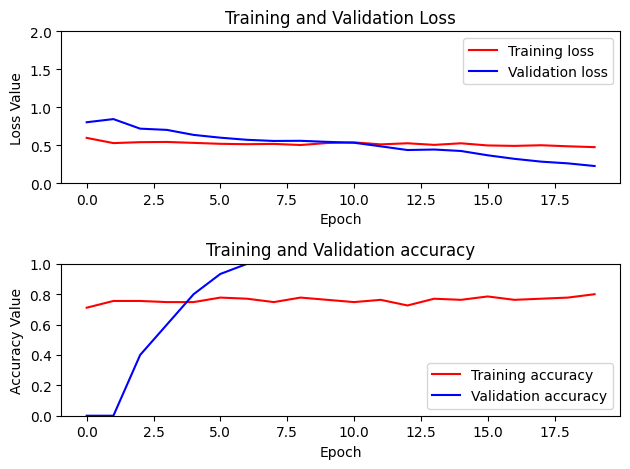

Fine-tuned Model:
Using 20 epochs. You can ignore the epochs parameter if you want to use all epochs.
Highest Validation Accuracy: 1.0


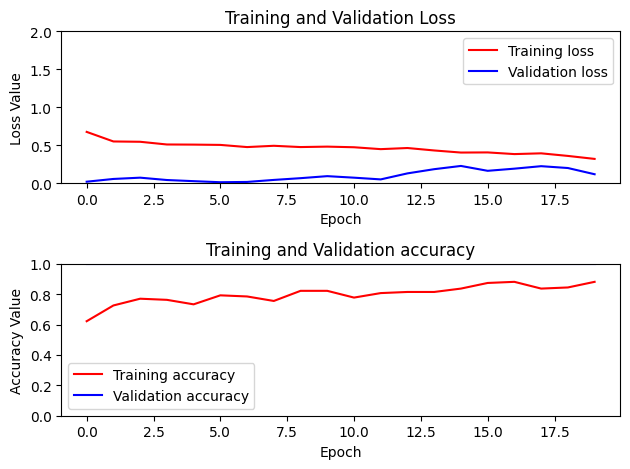

In [27]:
from src.Evaluation import plot_model_history

print('Model trained from scratch:')
plot_model_history(from_scratch_history.history, epochs=EPOCHS_PER_TRAINING)

print('Fine-tuned Model:')
plot_model_history(fine_tuned_history.history, epochs=EPOCHS_PER_TRAINING)